<h1 style="text-align: center"> Dogs emotions classifier </h1>

<img src='https://storage.googleapis.com/kaggle-datasets-images/2521291/4279172/aa31bd7b1579b7dc11f806a3dff54d9c/dataset-cover.jpg?t=2022-10-03-18-16-58' alt='Dog smile' />

## Data preparing

In [1]:
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
import pandas as pd
from tqdm import tqdm

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

___Dataset source___ - https://www.kaggle.com/datasets/devzohaib/dog-emotions-prediction

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! cd drive/MyDrive/files_for_colab/; unzip images_dogs_emotions.zip

In [5]:
images_path = 'drive/MyDrive/files_for_colab/images/'

In [6]:
df = pd.DataFrame(columns=['file', 'emotion'])

emotions = os.listdir(images_path)

for emotion in tqdm(emotions):
    images_names = pd.Series(os.listdir(images_path + emotion), name='file')
    images_names = emotion + '/' + images_names
    
    emotions_types = pd.Series(len(images_names) * [emotion], name='emotion')
    tmp_df = pd.concat([images_names, emotions_types], axis=1)
    
    df = pd.concat([df, tmp_df], ignore_index=True)
    
df

100%|██████████| 4/4 [00:00<00:00, 15.85it/s]


,file,emotion
0,angry/100035066_bb2792d5c8_b.jpg,angry
1,angry/10069504164_436856871c_b.jpg,angry
2,angry/1007148341_fdd49a7384_b.jpg,angry
3,angry/1007803967_b4b8ebc62c_b.jpg,angry
4,angry/10131474585_997d88e066_b.jpg,angry
...,...,...
15916,sad/9953954964_4330fdf081_b.jpg,sad
15917,sad/9959873844_67dce9ca9f_b.jpg,sad
15918,sad/9982050784_3765f84803_b.jpg,sad
15919,sad/9983838563_5683af739a_b.jpg,sad


In [7]:
labels_file = 'drive/MyDrive/files_for_colab/images_labels.csv'

In [8]:
df.to_csv(labels_file)

In [9]:
import torch

# 'happy' ==> [0, 1, 0, 0]
def label_to_class(label):
    labels = ['angry', 'happy', 'relaxed', 'sad']
    return torch.Tensor([float(label == l) for l in labels], )

# [0, 1, 0, 0] ==> 'happy'
def class_to_label(c):
    labels = ['angry', 'happy', 'relaxed', 'sad']
    idx = c.tolist().index(1)
    if idx >= len(labels):
        print('NO LABEL TO THIS CLASS')
        return None
    return labels[idx]

In [10]:
import os
import pandas as pd
from torchvision.io import read_image

class DogsEmotionsDataset(Dataset):
    def __init__(self, images_path, labels_csv_file_path, transform=None):
        self.images_path = images_path
        self.transform = transform
        self.labels = pd.read_csv(labels_csv_file_path)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = read_image(self.images_path + self.labels.iloc[idx, 1])
        label = label_to_class(self.labels.iloc[idx, 2])
        if self.transform:
            image = self.transform(image)
        return image, label

In [11]:
import torchvision.transforms as tfs

tf = tfs.Compose([
    tfs.Resize(224),
    tfs.ConvertImageDtype(torch.float32)
])

full_dataset = DogsEmotionsDataset(images_path, labels_file, tf)

In [12]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

In [13]:
train_data = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_data   = DataLoader(val_dataset,   batch_size=32, shuffle=True)

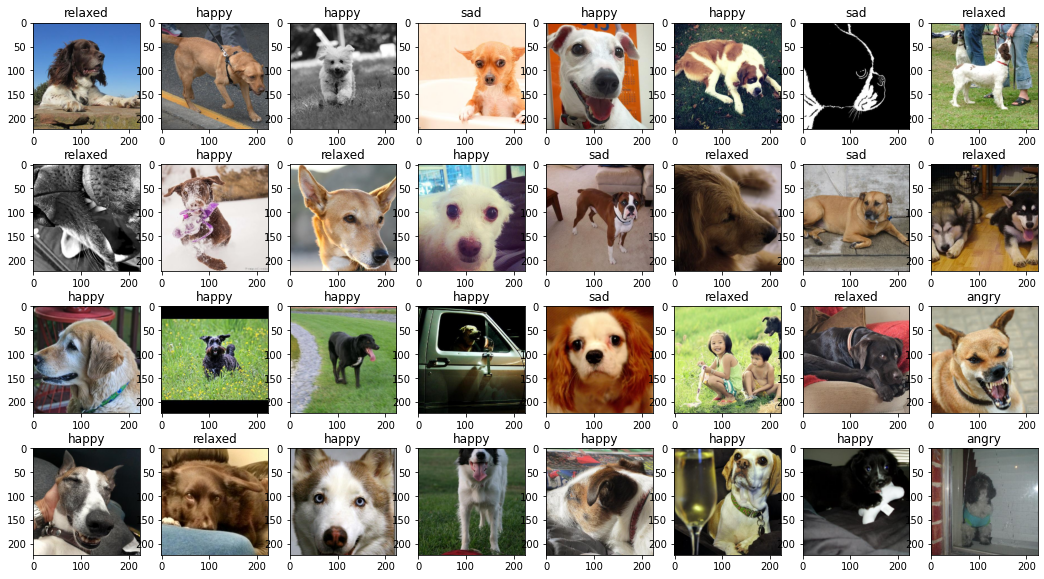

In [14]:
train_images, train_labels = next(iter(train_data))

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(class_to_label(train_labels[i]))

## Model building

In [89]:
from torchvision import models

model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)

In [90]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [111]:
import torch.nn as nn

classifier = nn.Sequential(
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=9216, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=4096),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=4096, out_features=256),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=256,  out_features=4)
)

In [112]:
model.classifier = classifier

In [113]:
# finetuning: pretrained conv. layers of AlexNet with custom FC
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Model training

In [94]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [116]:
def train(model, optim, criterion, train_data, val_data, epochs=20):
    losses = {
        'train': [],
        'val':   []
    }
    
    for epoch in tqdm(range(epochs)):
        # train
        model.train()
        train_loss = 0
        for X_batch, Y_batch in train_data:
            optim.zero_grad()
            X_batch_cuda = X_batch.to(device)
            Y_batch_cuda = Y_batch.to(device)
            X_pred_cuda = model(X_batch_cuda)
            loss = criterion(X_pred_cuda, Y_batch_cuda)
            loss.backward()
            optim.step()
            train_loss += loss
        losses['train'].append(train_loss.item() / len(train_data))
              
        # val
        model.eval()
        X_valbatch, Y_valbatch = next(iter(val_data))
        with torch.no_grad():
            X_valpred = model(X_valbatch.to(device))
        val_loss = criterion(X_valpred, Y_valbatch.to(device))
        losses['val'].append(val_loss.item())
        
        print(f'Epoch: {epoch + 1}/{epochs}; train_loss: {train_loss}; val_loss: {val_loss}')

    plt.plot(losses['train'], label='train loss')
    plt.plot(losses['val'],   label='val loss')
    plt.legend()
    return losses

In [114]:
optim = torch.optim.Adam(model.classifier.parameters())
criterion = torch.nn.MSELoss()

In [115]:
model = model.to(device)

 10%|█         | 1/10 [01:12<10:53, 72.66s/it]

Epoch: 1/10; train_loss: 269.2691650390625; val_loss: 0.17288988828659058


 20%|██        | 2/10 [02:23<09:33, 71.70s/it]

Epoch: 2/10; train_loss: 67.43212890625; val_loss: 0.16398698091506958


 30%|███       | 3/10 [03:32<08:13, 70.43s/it]

Epoch: 3/10; train_loss: 65.65565490722656; val_loss: 0.16719204187393188


 40%|████      | 4/10 [04:44<07:05, 70.92s/it]

Epoch: 4/10; train_loss: 64.7448501586914; val_loss: 0.17275476455688477


 50%|█████     | 5/10 [05:53<05:51, 70.25s/it]

Epoch: 5/10; train_loss: 63.68376541137695; val_loss: 0.1572304666042328


 60%|██████    | 6/10 [07:02<04:39, 69.95s/it]

Epoch: 6/10; train_loss: 62.762969970703125; val_loss: 0.14874476194381714


 70%|███████   | 7/10 [08:11<03:28, 69.58s/it]

Epoch: 7/10; train_loss: 61.95384216308594; val_loss: 0.17813003063201904


 80%|████████  | 8/10 [09:25<02:21, 70.99s/it]

Epoch: 8/10; train_loss: 61.27570343017578; val_loss: 0.16323453187942505


 90%|█████████ | 9/10 [10:34<01:10, 70.35s/it]

Epoch: 9/10; train_loss: 60.623844146728516; val_loss: 0.14369890093803406


100%|██████████| 10/10 [11:43<00:00, 70.36s/it]

Epoch: 10/10; train_loss: 59.584617614746094; val_loss: 0.15230602025985718


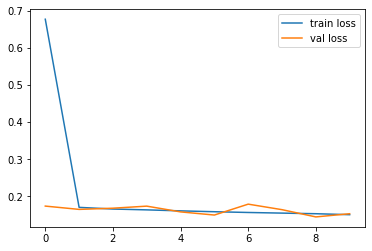

In [117]:
loss_history = train(model, optim, criterion, train_data, val_data, epochs=10)

## Model testing

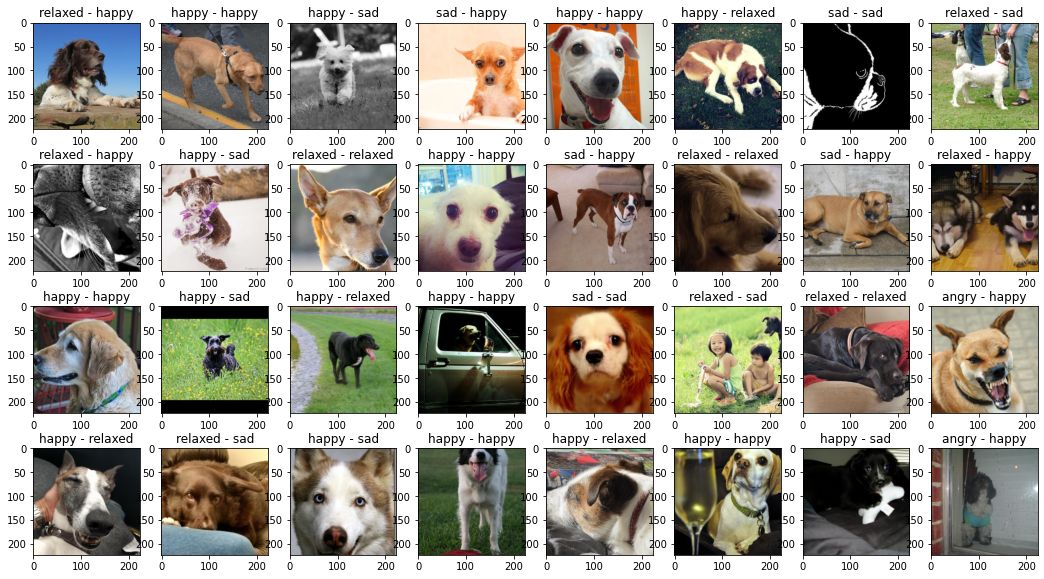

In [122]:
val_images, val_labels = next(iter(val_data))
emotions = os.listdir(images_path)
val_preds = model(val_images.to(device))

rows, cols = 4, 8
fig, axs = plt.subplots(rows, cols, figsize=(18, 10))

for i in range(rows * cols):
    r, c = i // cols, i % cols
    axs[r, c].imshow(np.transpose(train_images[i].numpy(), (1, 2, 0)))
    axs[r, c].title.set_text(f'{class_to_label(train_labels[i])} - {emotions[torch.argmax(val_preds[i]).item()]}')

In [127]:
def accuracy(model, test_data, light_cond=False):
    correct, all = 0, 0
    model.eval()
    light_list1 = ['happy', 'relaxed']
    light_list2 = ['sad', 'relaxed']

    with torch.no_grad():
        for X_batch, Y_batch in tqdm(test_data):
            for i in range(len(Y_batch)):
                val_preds = model(X_batch.to(device))
                all += 1

                if class_to_label(Y_batch[i]) == emotions[torch.argmax(val_preds[i]).item()]:
                    correct += 1
                elif light_cond and class_to_label(Y_batch[i]) in light_list1 and \
                    emotions[torch.argmax(val_preds[i]).item()] in light_list1:
                    correct += 1
                elif light_cond and class_to_label(Y_batch[i]) in light_list2 and \
                    emotions[torch.argmax(val_preds[i]).item()] in light_list2:
                    correct += 0.5
                    
    return correct / all

In [125]:
accuracy(model, val_data)

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


0.48948194662480377

In [128]:
# light mode: [happy = relaxed]->correct, [relaxed ~ sad]->(1/2)*correct
accuracy(model, val_data, True)

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


0.6869701726844584

## Summary

Some emotions are not so different (for example, happy and relaxed, sad and relaxed). They are difficult to distinguish even for a person.

The dataset is not perfectly marked up. There is a hypothesis that it is possible to improve the quality of the model by adding a few more emotions to the pictures (for example, emotion scared).